 # Defect Detection Pipeline
 ## 1. Install Dependencies

In [1]:
!pip install torch torchvision torchmetrics pandas pycocotools matplotlib
!pip install -U notebook ipykernel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 94.5 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 106.9 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 5.5.6
    Uninstalling ipykernel-5.5.6:
      Successfully uninstalled ipykernel-5.5.6
  Attempting uninstall: jupyter-lsp
    Found existing installation: jupyter-lsp 1.5.1
    Uninstalling jupyter-lsp-1.5.1:
      Successfully uninstalled jupyter-lsp-1.5.1
  Attempting uninstall: jupyterlab
    Found existing installation: jupyterlab 3.6.8
    Uninstalling jupyterlab-3.6.8:
      Successfully uninstalled jupyterlab-3.6.8
  Attempting uninstall: notebook
    Found existing installation: notebook 6.5.4
    Uninstalling notebook-6.5.4:
      Successfully uninstalled notebook-6.5.4
E

## 2. Data Preparation & Preprocessing

In [2]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from PIL import Image
from sklearn.model_selection import train_test_split

In [3]:
# Save DataFrames
dataset_path = "/kaggle/input/canned-food-surface-defect"
train_ann_path = os.path.join(dataset_path, "/kaggle/input/canned-food-surface-defect/train/_annotations.coco.json")
valid_ann_path = os.path.join(dataset_path, "/kaggle/input/canned-food-surface-defect/valid/_annotations.coco.json")
test_ann_path = os.path.join(dataset_path, "/kaggle/input/canned-food-surface-defect/test/_annotations.coco.json")

In [4]:
def process_coco_annotations(ann_path, image_dir):
    """Process COCO annotations to create binary labels"""
    coco = COCO(ann_path)
    image_ids = coco.getImgIds()
    images = coco.loadImgs(image_ids)
    
    data = []
    for img in images:
        ann_ids = coco.getAnnIds(imgIds=img['id'])
        annotations = coco.loadAnns(ann_ids)
        
        label = 0  # Default to no defect
        for ann in annotations:
            if ann['category_id'] in [1, 2, 3]:  # Defect categories
                label = 1
                break  # Prioritize defect label
            elif ann['category_id'] == 4:        # No defect
                label = 0
                break
                
        img_path = os.path.join(image_dir, img['file_name'])
        data.append({
            'image_path': img_path,
            'width': img['width'],
            'height': img['height'],
            'label': label
        })
    
    return pd.DataFrame(data)

In [5]:
# Process all splits
train_df = process_coco_annotations(train_ann_path, os.path.join(dataset_path, "train"))
valid_df = process_coco_annotations(valid_ann_path, os.path.join(dataset_path, "valid"))
test_df = process_coco_annotations(test_ann_path, os.path.join(dataset_path, "test"))

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [6]:
os.makedirs('processed_data', exist_ok=True)
train_df.to_csv('processed_data/train.csv', index=False)
valid_df.to_csv('processed_data/valid.csv', index=False)
test_df.to_csv('processed_data/test.csv', index=False)

## 3. Dataset Visualization

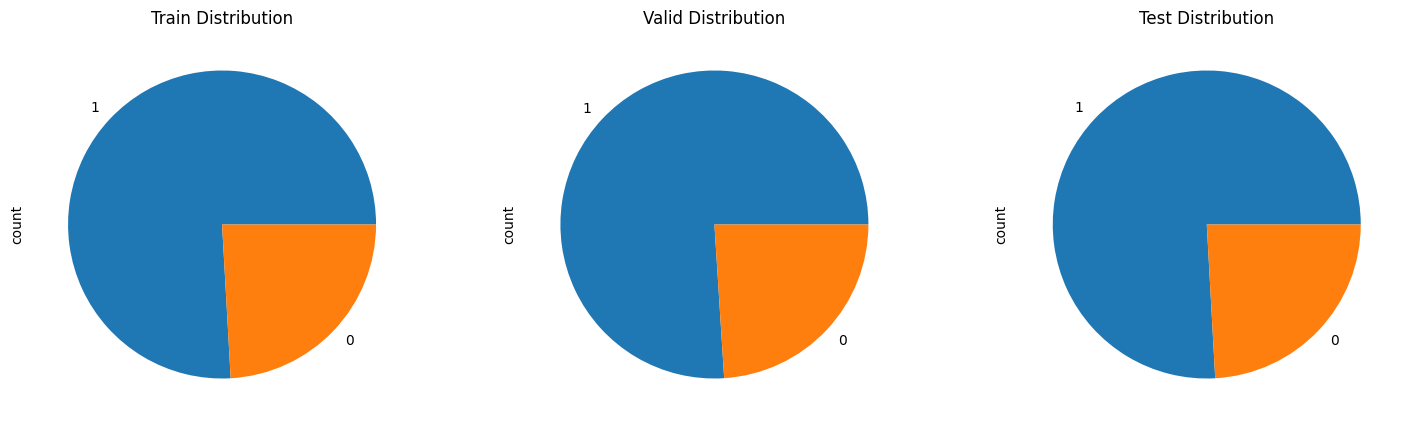

In [7]:
# Display class distribution
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
train_df['label'].value_counts().plot(kind='pie', ax=ax[0], title='Train Distribution')
valid_df['label'].value_counts().plot(kind='pie', ax=ax[1], title='Valid Distribution')
test_df['label'].value_counts().plot(kind='pie', ax=ax[2], title='Test Distribution')
plt.show()

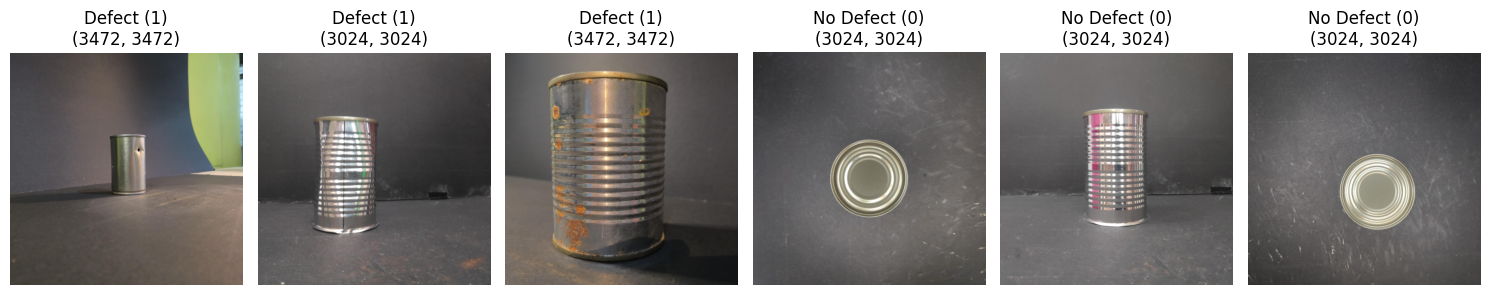

In [8]:
# %%
# Display sample images
def plot_samples(df, n=3):
    plt.figure(figsize=(15, 5))
    for i, (_, row) in enumerate(df[df['label'] == 1].sample(n).iterrows()):
        plt.subplot(1, n*2, i+1)
        img = Image.open(row['image_path'])
        plt.imshow(img)
        plt.title(f"Defect (1)\n{img.size}")
        plt.axis('off')
    
    for i, (_, row) in enumerate(df[df['label'] == 0].sample(n).iterrows()):
        plt.subplot(1, n*2, i+1+n)
        img = Image.open(row['image_path'])
        plt.imshow(img)
        plt.title(f"No Defect (0)\n{img.size}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_samples(train_df)


## 4. Create PyTorch Dataset

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class FoodDefectDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        label = self.df.iloc[idx]['label']
        
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), torch.tensor(label, dtype=torch.float32)

In [10]:
# Create datasets
train_dataset = FoodDefectDataset(train_df, transform=transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))

valid_dataset = FoodDefectDataset(valid_df)
test_dataset = FoodDefectDataset(test_df)

# Create dataloaders
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2)

## 5. Model Training


In [11]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
from torchmetrics import Accuracy, F1Score

In [12]:
def create_model(model_name='resnet50'):
    if model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, 1)
    elif model_name == 'efficientnet':
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
    return model

In [13]:
def train_model(model, train_loader, valid_loader, epochs=30, lr=1e-4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
    
    metrics = {
        'train_loss': [],
        'valid_loss': [],
        'valid_acc': [],
        'valid_f1': []
    }
    
    best_f1 = 0.0
    patience = 5 
    epochs_without_improvement = 0
    accuracy = Accuracy(task='binary').to(device)
    f1 = F1Score(task='binary').to(device)
    
    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        # Validation
        model.eval()
        valid_loss = 0.0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).squeeze()
                
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * inputs.size(0)
                
                preds = (torch.sigmoid(outputs) > 0.5).int()
                all_preds.append(preds)
                all_labels.append(labels.int())
        
        # Aggregate predictions
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)

        # Calculate metrics
        train_loss = running_loss / len(train_loader.dataset)
        valid_loss = valid_loss / len(valid_loader.dataset)
        valid_acc = accuracy(all_preds, all_labels).item()
        valid_f1 = f1(all_preds, all_labels).item()
        
        # Update metrics
        metrics['train_loss'].append(train_loss)
        metrics['valid_loss'].append(valid_loss)
        metrics['valid_acc'].append(valid_acc)
        metrics['valid_f1'].append(valid_f1)
        
        # Save the best model based on validation F1 score
        if valid_f1 > best_f1:
            best_f1 = valid_f1
            torch.save(model.state_dict(), f'best_{model.__class__.__name__}.pth')
            epochs_without_improvement = 0  # Reset counter
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping after {epoch + 1} epochs")
            break
            
        # Update learning rate based on validation loss
        scheduler.step(valid_loss)
        
        # Print epoch summary
        print(f'\nEpoch {epoch+1}/{epochs}')
        print(f'Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}')
        print(f'Valid Acc: {valid_acc:.4f} | Valid F1: {valid_f1:.4f}')
        print('-'*50)
    
    return model, metrics


In [14]:
# Train ResNet50
resnet = create_model('resnet50')
resnet, resnet_metrics = train_model(
    resnet, train_loader, valid_loader, epochs=30, lr=1e-4
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 210MB/s] 
Epoch 1/30: 100%|██████████| 354/354 [04:42<00:00,  1.25it/s]



Epoch 1/30
Train Loss: 0.1358 | Valid Loss: 0.0256
Valid Acc: 0.9882 | Valid F1: 0.9922
--------------------------------------------------


Epoch 2/30: 100%|██████████| 354/354 [06:22<00:00,  1.08s/it]



Epoch 2/30
Train Loss: 0.0755 | Valid Loss: 0.0304
Valid Acc: 0.9863 | Valid F1: 0.9909
--------------------------------------------------


Epoch 3/30: 100%|██████████| 354/354 [06:25<00:00,  1.09s/it]



Epoch 3/30
Train Loss: 0.0583 | Valid Loss: 0.0034
Valid Acc: 1.0000 | Valid F1: 1.0000
--------------------------------------------------


Epoch 4/30: 100%|██████████| 354/354 [05:53<00:00,  1.00it/s]



Epoch 4/30
Train Loss: 0.0424 | Valid Loss: 0.0056
Valid Acc: 0.9988 | Valid F1: 0.9992
--------------------------------------------------


Epoch 5/30: 100%|██████████| 354/354 [06:25<00:00,  1.09s/it]



Epoch 5/30
Train Loss: 0.0491 | Valid Loss: 0.0051
Valid Acc: 0.9988 | Valid F1: 0.9992
--------------------------------------------------


Epoch 6/30: 100%|██████████| 354/354 [05:06<00:00,  1.16it/s]



Epoch 6/30
Train Loss: 0.0478 | Valid Loss: 0.0039
Valid Acc: 0.9994 | Valid F1: 0.9996
--------------------------------------------------


Epoch 7/30: 100%|██████████| 354/354 [06:30<00:00,  1.10s/it]



Epoch 7/30
Train Loss: 0.0328 | Valid Loss: 0.0018
Valid Acc: 1.0000 | Valid F1: 1.0000
--------------------------------------------------


Epoch 8/30: 100%|██████████| 354/354 [05:52<00:00,  1.01it/s]


Early stopping after 8 epochs


In [15]:
# Train EfficientNet
effnet = create_model('efficientnet')
effnet, effnet_metrics = train_model(
    effnet, train_loader, valid_loader, epochs=30, lr=1e-4
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 139MB/s] 
Epoch 1/30: 100%|██████████| 354/354 [04:45<00:00,  1.24it/s]



Epoch 1/30
Train Loss: 0.1845 | Valid Loss: 0.0424
Valid Acc: 0.9876 | Valid F1: 0.9918
--------------------------------------------------


Epoch 2/30: 100%|██████████| 354/354 [06:21<00:00,  1.08s/it]



Epoch 2/30
Train Loss: 0.0623 | Valid Loss: 0.0114
Valid Acc: 0.9981 | Valid F1: 0.9988
--------------------------------------------------


Epoch 3/30: 100%|██████████| 354/354 [06:31<00:00,  1.11s/it]



Epoch 3/30
Train Loss: 0.0487 | Valid Loss: 0.0085
Valid Acc: 0.9994 | Valid F1: 0.9996
--------------------------------------------------


Epoch 5/30: 100%|██████████| 354/354 [06:30<00:00,  1.10s/it]



Epoch 5/30
Train Loss: 0.0356 | Valid Loss: 0.0054
Valid Acc: 0.9981 | Valid F1: 0.9988
--------------------------------------------------


Epoch 6/30: 100%|██████████| 354/354 [06:38<00:00,  1.13s/it]



Epoch 6/30
Train Loss: 0.0245 | Valid Loss: 0.0040
Valid Acc: 0.9988 | Valid F1: 0.9992
--------------------------------------------------


Epoch 7/30: 100%|██████████| 354/354 [06:38<00:00,  1.12s/it]



Epoch 7/30
Train Loss: 0.0330 | Valid Loss: 0.0122
Valid Acc: 0.9938 | Valid F1: 0.9959
--------------------------------------------------


Epoch 8/30: 100%|██████████| 354/354 [06:35<00:00,  1.12s/it]


Early stopping after 8 epochs


## 6. Model Evaluation

In [20]:
from torchmetrics.classification import Precision, Recall

def evaluate_model(model, test_loader, model_name):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.load_state_dict(torch.load(f'best_{model.__class__.__name__}.pth'))
    model.eval()
    
    criterion = nn.BCEWithLogitsLoss()
    test_loss = 0.0
    all_preds = []
    all_labels = []
    
    accuracy = Accuracy(task='binary').to(device)
    f1 = F1Score(task='binary').to(device)
    precision = Precision(task='binary').to(device)
    recall = Recall(task='binary').to(device)
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc=f'Evaluating {model_name}'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            
            test_loss += criterion(outputs, labels).item() * inputs.size(0)
            preds = torch.sigmoid(outputs) > 0.5
            
            all_preds.append(preds)
            all_labels.append(labels)
    
    # Calculate metrics
    test_loss = test_loss / len(test_loader.dataset)
    final_acc = accuracy(torch.cat(all_preds), torch.cat(all_labels))
    final_f1 = f1(torch.cat(all_preds), torch.cat(all_labels))
    final_precision = precision(torch.cat(all_preds), torch.cat(all_labels))
    final_recall = recall(torch.cat(all_preds), torch.cat(all_labels))
    
    # Print results
    print(f'\n{model_name} Results:')
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Accuracy: {final_acc:.4f} | F1 Score: {final_f1:.4f}')
    print(f'Precision: {final_precision:.4f} | Recall: {final_recall:.4f}')
    
    return {
        'model': model_name,
        'test_loss': test_loss,
        'accuracy': final_acc.cpu().item(),
        'f1': final_f1.cpu().item(),
        'precision': final_precision.cpu().item(),
        'recall': final_recall.cpu().item()
    }

In [21]:
resnet_results = evaluate_model(resnet, test_loader, 'ResNet50')
effnet_results = evaluate_model(effnet, test_loader, 'EfficientNet')

<ipython-input-20-73a204663762>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_{model.__class__.__name__}.pth'))
Evaluating ResNet5


ResNet50 Results:
Test Loss: 0.0122
Accuracy: 0.9988 | F1 Score: 0.9992
Precision: 0.9984 | Recall: 1.0000


Evaluating EfficientNet: 100%|██████████| 52/52 [01:01<00:00,  1.19s/it]


EfficientNet Results:
Test Loss: 0.0174
Accuracy: 0.9988 | F1 Score: 0.9992
Precision: 0.9984 | Recall: 1.0000


In [22]:
# Compare model performance
results_df = pd.DataFrame([resnet_results, effnet_results])
print('\nModel Comparison:')
display(results_df)


Model Comparison:


,model,test_loss,accuracy,f1,precision,recall
0,ResNet50,0.012231,0.998794,0.999206,0.998413,1.0
1,EfficientNet,0.017418,0.998794,0.999206,0.998413,1.0


## 7. Training Monitoring

In [23]:
def plot_training_metrics(metrics, model_name):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_loss'], label='Train Loss')
    plt.plot(metrics['valid_loss'], label='Valid Loss')
    plt.title(f'{model_name} Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(metrics['valid_acc'], label='Accuracy')
    plt.plot(metrics['valid_f1'], label='F1 Score')
    plt.title(f'{model_name} Validation Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

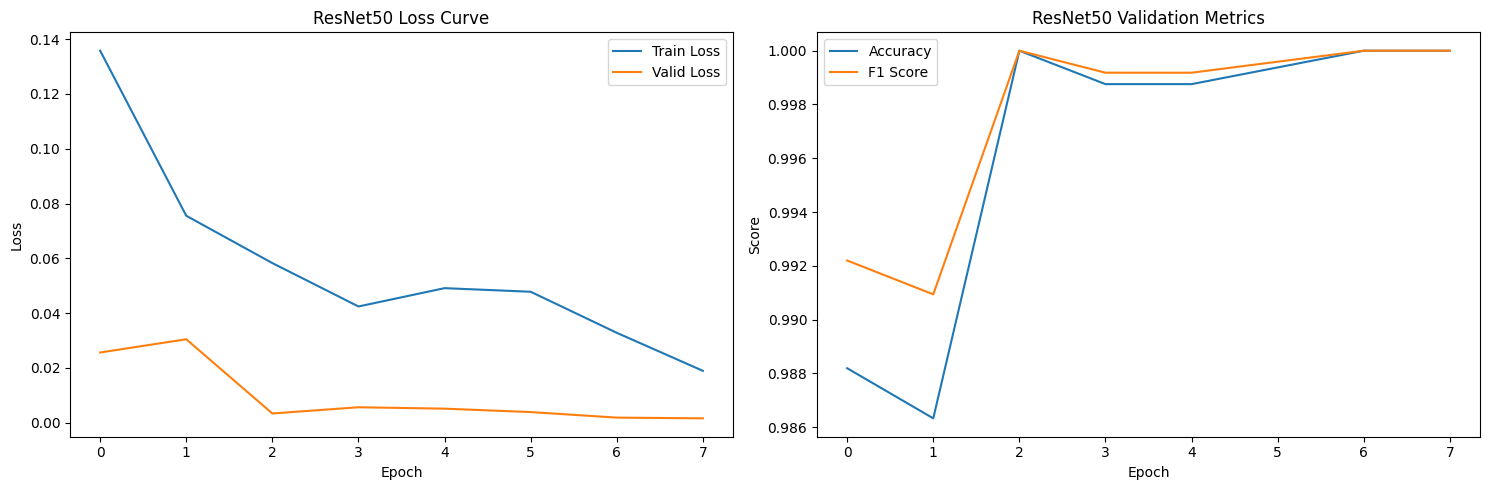

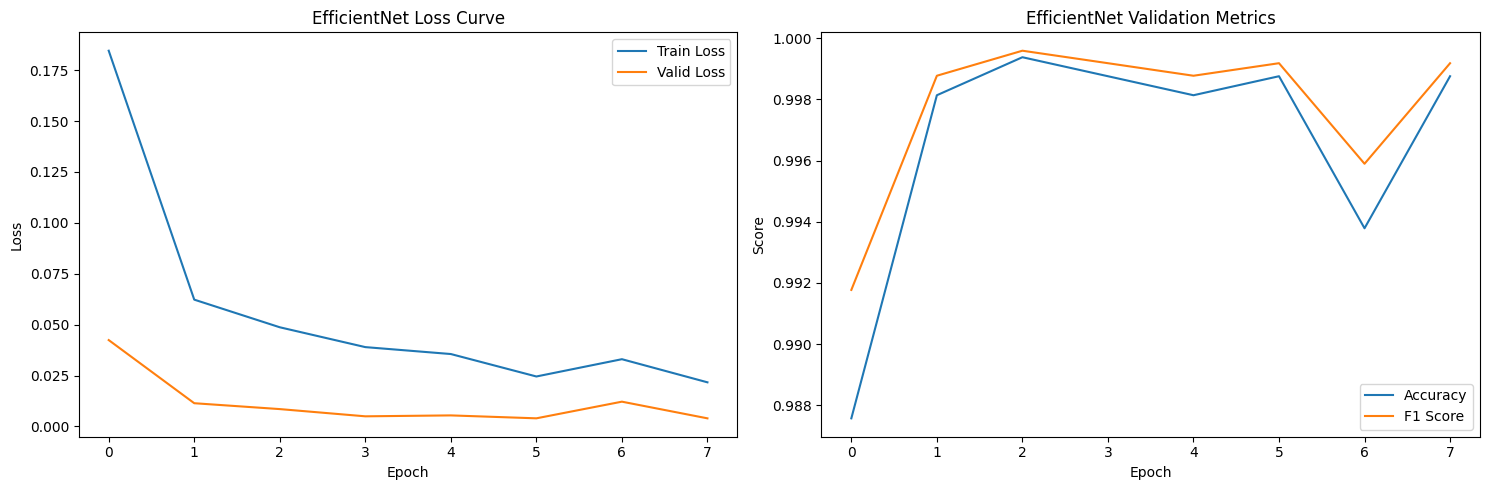

In [24]:
plot_training_metrics(resnet_metrics, 'ResNet50')
plot_training_metrics(effnet_metrics, 'EfficientNet')


## 8. Pipeline Automation

In [25]:
# Save final pipeline
torch.save(resnet.state_dict(), 'defect_detection_resnet50.pth')
torch.save(effnet.state_dict(), 'defect_detection_efficientnet.pth')

In [26]:
# Inference function template
def predict_defect(image_path, model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(img_tensor)
        prob = torch.sigmoid(output).item()
    
    return 'Defect' if prob > 0.5 else 'No Defect', prob

Prediction (ResNet): No Defect, Confidence: 1.0422592822578736e-05
Prediction (EfficientNet): No Defect, Confidence: 0.002713307272642851


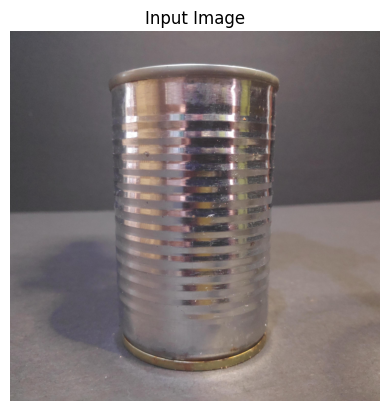

In [32]:
import matplotlib.pyplot as plt
import cv2

image_path = '/kaggle/input/canned-food-surface-defect/test/IMG_20220624_152256_jpg.rf.2d475f36b8e63a95b8bd52660f5808ee.jpg'
image = cv2.imread(image_path)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Predict using resnet
prediction_resnet, confidence_resnet = predict_defect(image_path, resnet)
print(f"Prediction (ResNet): {prediction_resnet}, Confidence: {confidence_resnet}")

# Predict using efficientnet
prediction_effnet, confidence_effnet = predict_defect(image_path, effnet)
print(f"Prediction (EfficientNet): {prediction_effnet}, Confidence: {confidence_effnet}")

plt.imshow(image)
plt.axis('off') 
plt.title("Input Image")
plt.show()


## 9. Results Summary
 
 | Model        | Accuracy     | F1 Score     | Precision     | Recall     | Test Loss     |
 |--------------|--------------|--------------|---------------|------------|---------------|
 | ResNet50     | 0.998794     | 0.999206     | 0.998413      | 1.0        | 0.012231      |
 | EfficientNet | 0.998794     | 0.999206     | 0.998413      | 1.0        | 0.017418      |
 